In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import logomaker

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('sortseq')
data_df.head()

,x,training_set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9
0,AAATACACACTTGCTGCTTCCGGCTCGTATGTTGTGTGG,True,0,0,0,1,0,0,0,0,0,0
1,AAATTTACACTGTATGCTTCCGGCTCGCATGGCGTTTGC,False,0,0,1,0,0,0,0,0,0,0
2,AAATTTACACTTTATGCATCAGACTCGTATGTTGTGTGG,True,1,0,0,0,0,0,0,0,0,0
3,AAATTTACACTTTATGCTTCTGGCGCGTATGCGGCGTGG,False,0,0,0,1,0,0,0,0,0,0
4,AACATTACATTTTATGCTTCCGGCTCGTATGGTGTGTGG,False,0,1,0,0,0,0,0,0,0,0


In [3]:
# Comptue sequence length and number of bins
L = len(data_df['x'][0])
y_cols = [c for c in data_df.columns if 'ct_' in c]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=39, Y=10


In [4]:
# Split into trianing and test data
ix = data_df['training_set']
L = len(data_df['x'][0])
train_df = data_df[ix]
print(f'training N: {len(train_df):,}')
test_df = data_df[~ix]
print(f'testing N: {len(test_df):,}')

training N: 36,517
testing N: 9,261


In [5]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(regression_type='MPA',
                     L=L,
                     Y=Y,
                     alphabet='dna',
                     gpmap_type='additive')

# Where is ct_n?
model.set_data(x=data_df['x'].values,
               y=data_df[y_cols].values)

# Fit model to data
history = model.fit(learning_rate=.001,
                    epochs=1000,
                    batch_size=250,
                    early_stopping=True,
                    early_stopping_patience=10)

N = 45,778 observations set as training data.
Data shuffled.
Time to set data: 0.431 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has    45778 rows  and      156 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      156

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.121e+03  1.109e+06   1.0e+00  8.8e-01
     1  5.87823e-03  6.106e+02  2.107e+04   5.4e-01  2.9e-02  1.2e+03  1.0e+00
     2  3.96569e-02  5.511e+02  5.287e+03   4.9e-01  8.1e-03  1.2e+03  1.5e+01
     3  2.84491e-04  5.426e+02  2.711e+03   4.8e-01  4.2e-03  1.2e+03  2.2e+01
     4 -4.92255e-02  5.397e+02  9.406e+02   4.8e-01  1.5e-03  1.2e+03  2.2e+01
     5 -4.93635e-02  5.395e+02  6.487e+02   4.8e-01  1.0e-03  1.2e+03  2.1e+01
     6 -4.94175e-02  5.394e+02  4.418e+02   4.8e-01  5.3e-04  1.5e+03  2.1e+01
     7 -4.89264e-02  5.394e+02  1.420e+02   4.8e-01  1.6e-04  1

147/147 [==============================] - 0s 1ms/step - loss: 693.4961 - I_like: 0.3387 - val_loss: 697.7145 - val_I_like: 0.3292
Epoch 47/1000
147/147 [==============================] - 0s 1ms/step - loss: 693.3959 - I_like: 0.3387 - val_loss: 698.3871 - val_I_like: 0.3263
Epoch 48/1000
147/147 [==============================] - 0s 1ms/step - loss: 693.3602 - I_like: 0.3389 - val_loss: 697.7173 - val_I_like: 0.3292
Epoch 49/1000
147/147 [==============================] - 0s 1ms/step - loss: 693.4827 - I_like: 0.3392 - val_loss: 698.0635 - val_I_like: 0.3275
Epoch 50/1000
147/147 [==============================] - 0s 1ms/step - loss: 693.4844 - I_like: 0.3382 - val_loss: 697.7115 - val_I_like: 0.3290
Epoch 51/1000
147/147 [==============================] - 0s 1ms/step - loss: 693.5745 - I_like: 0.3380 - val_loss: 698.1434 - val_I_like: 0.3270
Epoch 52/1000
147/147 [==============================] - 0s 1ms/step - loss: 693.3846 - I_like: 0.3393 - val_loss: 697.8010 - val_I_like: 0.3286

In [6]:
# Save model
model.save('sortseq_mpa_additive')

Model saved to these files:
	sortseq_mpa_additive.pickle
	sortseq_mpa_additive.h5


In [7]:
# Load model
model = mavenn.load('sortseq_mpa_additive')

Model loaded from these files:
	sortseq_mpa_additive.pickle
	sortseq_mpa_additive.h5


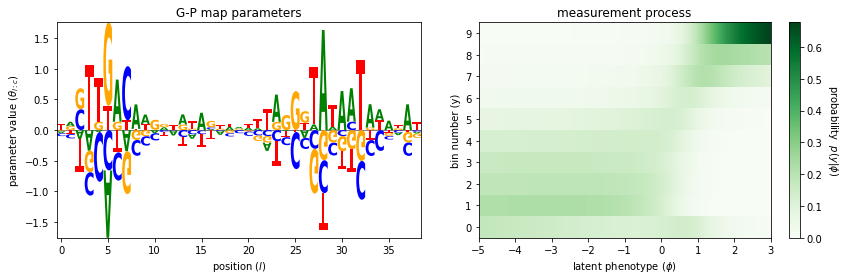

In [8]:
# Get G-P map parameters in matrix form
theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(theta['logomaker_df'], ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
ax = axs[1]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('sortseq_mpa_visualization.png')
plt.show()

In [9]:
model.simulate_dataset(N=100)

,training_set,phi,x,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9
0,False,-0.688363,CGCTTTTCACTGCAGGCTTCCGGCTCGAATGTTGTGTGG,0,0,1,0,0,0,0,0,0,0
1,True,0.571798,GGCTTTACACTTTATGCTTCCGGCTCGTATGTTTTGTGG,0,0,0,0,0,0,0,0,1,0
2,True,0.599094,CCTTTTACACTCTATGCTACAGGCTAGTATGTTGTACGG,0,0,0,0,0,0,0,0,1,0
3,True,-0.258418,GGCTTTCCACTTTATCCTTCAGGCTCATATGTTGTGGGC,0,1,0,0,0,0,0,0,0,0
4,True,0.658813,GGCTTTACACTTTCTGCTTCCGGCTCGTATGTTGTGTGT,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,True,-0.815449,GGCTTTGGACGTCATGCTGCCGGCTCGTATGTTGTGTGG,0,0,1,0,0,0,0,0,0,0
96,False,0.634165,GGATTGACACTTAAAGCTTTCCGCTCGTATGTTCTGTGG,0,0,0,0,0,0,0,1,0,0
97,True,0.211771,GGCTTAACACGTTCTGCTTCCGGATTGTATTTTCTGTGC,0,0,0,0,1,0,0,0,0,0
98,True,1.898037,GTCTTTACACTCTATGCTTCGCGCGGGTATGTTGTCTTG,0,0,0,0,0,0,0,0,1,0
